In [1]:
import requests
from bs4 import BeautifulSoup

api_page = requests.get("https://scikit-learn.org/1.4/modules/classes.html")
soup = BeautifulSoup(api_page.content, 'html.parser')

In [2]:
h2_elements = soup.find_all('h2')

In [3]:
sections = []
for i in range(len(h2_elements) - 1):
    section = []
    for sibling in h2_elements[i].next_siblings:
        if sibling == h2_elements[i + 1]:
            break
        section.append(str(sibling))
    section_text = ''.join(section)
    sections.append(BeautifulSoup(section_text, 'lxml'))

In [4]:
import re
def clean_text(text):
    text = re.sub("\xa0","",text)
    text = re.sub("¶","",text)
    text = re.sub("\n","",text)
    return text.strip()
def get_links(*,sub_section_elem,class_name,base_func_url,title):
    curr_urls = []
    try:
        func_urls = sub_section_elem.find_all(attrs={"class": class_name})
        for curr_url in func_urls:
            try:
                func_url = curr_url.find("a")["href"]
                func_text = curr_url.text
                if func_text.find(")") == -1:
                    separator = "\n"
                else:
                    separator = ")"
                func_name,func_desc = func_text[:func_text.find(separator)+1].strip("\n"),func_text[func_text.find(separator)+1:].strip("\n")
                # curr_urls.append(base_func_url + func_url)
                curr_urls.append({"name":func_name,"description":func_desc, "url":base_func_url + func_url})
            except Exception as e:
                print(e)
                print(title.text)
        return curr_urls
    except Exception as e:
        curr_url = sub_section_elem.find(attrs={"class": class_name})
        func_url = curr_url.find('a')["href"]
        func_text = curr_url.text
        if func_text.find(")") == -1:
            separator = "\n"
        else:
            separator = ")"
        func_name,func_desc = func_text[:func_text.find(separator)+1].strip("\n"),func_text[func_text.find(separator)+1:].strip("\n")
        curr_urls.append({"name":clean_text(func_name),"description":func_desc, "url":base_func_url + func_url})
        return curr_urls
    finally:
        return curr_urls

In [5]:
def get_sub_level_dict(h3_titles_list,base_sklearn_url):
    sub_level_dict = {}
    for idx,h3_title in enumerate(h3_titles_list):
        h3_title_text = clean_text(h3_title.text)
        title_siblings = []
        # If it is not the last element
        if idx != len(h3_titles_list)-1:
            for title_functions_siblings in h3_title.next_siblings:
                if title_functions_siblings == h3_titles_list[idx+1]: break
                title_siblings.append(str(title_functions_siblings))
            title_siblings_text = ''.join(title_siblings)
            title_siblings_soup = BeautifulSoup(title_siblings_text, 'lxml')
        else:
            for title_functions_siblings in h3_title.next_siblings:
                title_siblings.append(str(title_functions_siblings))
            title_siblings_text = ''.join(title_siblings)
            title_siblings_soup = BeautifulSoup(title_siblings_text, 'lxml')
        odd_urls = get_links(sub_section_elem=title_siblings_soup,class_name="row-odd",base_func_url=base_sklearn_url,title=h3_title)
        even_urls = get_links(sub_section_elem=title_siblings_soup,class_name="row-even",base_func_url=base_sklearn_url,title=h3_title)
        all_urls = odd_urls + even_urls
        sub_level_dict.update({h3_title_text:{'functions':all_urls}})
    return sub_level_dict

In [6]:
# from tqdm import tqdm

# parent_dict = {}
# pbar = tqdm(total=len(h2_elements[:-1]),desc="Scraping Sklearn")
# for sub_section_h2,sub_section in zip(h2_elements[:-1],sections):
#     base_sklearn_url = "https://scikit-learn.org/stable/modules/"
#     base_parent_url = "https://scikit-learn.org/stable/modules/classes.html"
#     # sub_section = sections[1]
#     # sub_section_h2 = h2_elements[1]
#     parent_class_href = sub_section_h2.find('a')['href']
#     parent_name = clean_text(sub_section_h2.text)
#     parent_function = parent_name.split(":")[0]
#     parent_name = parent_name.split(":")[1].strip()
#     parent_text = " ".join([para.text for para in sub_section.find_all('p')])
#     if "h3" in str(sub_section):
#         try:
#             h3_titles_list = sub_section.find_all('h3')
#             sub_level_dict = get_sub_level_dict(h3_titles_list,base_sklearn_url)
#         except:
#             h3_titles_list = [sub_section.find('h3')]
#         sub_level_dict = get_sub_level_dict(h3_titles_list,base_sklearn_url)
#         for sub_level,vals in sub_level_dict.items():
#             if vals['functions'] == []:
#                 odd_urls = get_links(sub_section_elem=sub_section,class_name="row-odd",base_func_url=base_sklearn_url,title=sub_section_h2)
#                 even_urls = get_links(sub_section_elem=sub_section,class_name="row-even",base_func_url=base_sklearn_url,title=sub_section_h2)
#                 all_urls = odd_urls + even_urls
#                 sub_level_dict = {parent_name:{'functions':all_urls}}
#     elif "h3" not in str(sub_section):
#         odd_urls = get_links(sub_section_elem=sub_section,class_name="row-odd",base_func_url=base_sklearn_url,title=sub_section_h2)
#         even_urls = get_links(sub_section_elem=sub_section,class_name="row-even",base_func_url=base_sklearn_url,title=sub_section_h2)
#         all_urls = odd_urls + even_urls
#         sub_level_dict = {parent_name:{'functions':all_urls}}
#     parent_dict.update({parent_name:{"functions":parent_function,"url":base_parent_url+parent_class_href,"sub_level_dict":sub_level_dict,"parent_text":parent_text}})
#     pbar.update(1)

In [7]:
from tqdm import tqdm

parent_dict = {}
pbar = tqdm(total=len(h2_elements[:-1]),desc="Scraping Sklearn")
for sub_section_h2,sub_section in zip(h2_elements[:-1],sections):
    base_sklearn_url = "https://scikit-learn.org/stable/modules/"
    base_parent_url = "https://scikit-learn.org/stable/modules/classes.html"
    # sub_section = sections[1]
    # sub_section_h2 = h2_elements[1]
    parent_class_href = sub_section_h2.find('a')['href']
    parent_name = clean_text(sub_section_h2.text)
    parent_function = clean_text(parent_name.split(":")[0])
    parent_name = parent_name.split(":")[1].strip()
    parent_text = " ".join([para.text for para in sub_section.find_all('p')])
    try:
        default_funcs = []
        default_vals_list = []
        defaul_vals = sub_section.find_all(class_="autosummary longtable docutils align-default")
        for df in defaul_vals:
            ourl = get_links(sub_section_elem=sub_section,class_name="row-odd",base_func_url=base_sklearn_url,title=sub_section_h2)
            eurl = get_links(sub_section_elem=sub_section,class_name="row-even",base_func_url=base_sklearn_url,title=sub_section_h2)
            default_funcs.extend(ourl + eurl)
        parent_dict.update({parent_name:{"base_function":parent_function,"url":base_parent_url+parent_class_href,"functions":default_funcs,"parent_text":parent_text}})
    except:
        pass

    if "h3" in str(sub_section):
        try:
            h3_titles_list = sub_section.find_all('h3')
        except:
            h3_titles_list = [sub_section.find('h3')]
        sub_level_dict = get_sub_level_dict(h3_titles_list,base_sklearn_url)
        parent_dict[parent_name].update({"sub_level_dict":sub_level_dict})
    pbar.update(1)

Scraping Sklearn:   0%|          | 0/39 [00:00<?, ?it/s]

Scraping Sklearn:  59%|█████▉    | 23/39 [00:00<00:00, 179.54it/s]

In [8]:
from markdownify import MarkdownConverter

# Create shorthand method for conversion
def md(soup, **options):
    return MarkdownConverter(**options).convert_soup(soup)

In [1]:
# import re
# import sys

# def normalize_newlines(paragraph):
#     normalized_paragraph = re.sub(r'\n+', '\n\n', paragraph)
#     return normalized_paragraph
# def remove_links(soup):
#         links = soup.find_all('a')
#         for link in links:
#             link.decompose()
        
#         return soup
# def get_py_obj(base_func_url,parent_name):
#     func_url = requests.get(base_func_url)
#     func_soup = BeautifulSoup(func_url.content, 'lxml')
#     func_name = clean_text(func_soup.find('h1').text)
#     func_signature_elem = func_soup.find(class_="sig sig-object py")
#     if func_signature_elem is not None:
#         func_signature = clean_text(func_signature_elem.text)
#     else:
#         func_signature = ""
#     all_urls = []
#     page_dict = {"func_name":func_name,"func_signature":func_signature}
#     try:
#         if func_soup.find(class_="py class"):
#             class_or_fn = "py class"
#             type = "class"
#         elif func_soup.find(class_="py function"):
#             class_or_fn = "py function"
#             type = "function"
#         py_soup = func_soup.find(class_=class_or_fn)
#         func_text_list = []
#         dd = py_soup.find('dd')
#         field_list = dd.find(class_="field-list")

#         for i in field_list.previous_siblings:
#             func_text_list.append(i.text)
#         func_text = "".join(func_text_list[::-1]).replace("\n"," ").strip()
#         page_dict.update({"func_text":func_text})
#         for url in py_soup.find_all('a'):
#             url = url['href']
#             if url is None: continue
#             elif url.startswith("#"):
#                 all_urls.append(base_func_url + url)
#             elif url.startswith(".."):
#                 continue
#             elif url.startswith("http"):
#                 all_urls.append(url)
#         py_soup = remove_links(py_soup)
#         py_md = normalize_newlines(md(py_soup))
#         page_dict.update({"func_md":py_md,"type":type})
#         fodd = field_list.find_all(class_="field-odd")
#         if fodd[0].text == "Parameters":
#             dts = fodd[1].find_all('dt')
#             paremter_names_desc = {}

#             for idx,dt in enumerate(dts):
#                 param_name = dt.find('strong').text
#                 param_type = dt.find(class_="classifier").text
#                 param_desc = ""
#                 for next_sib in dt.next_siblings:
#                     if idx == len(dts)-1:
#                         pass
#                     else:
#                         if next_sib == dts[idx+1]:
#                             break
#                     next_sib = str(next_sib)
#                     param_desc += next_sib[next_sib.find("<p>"):next_sib.find("</p>")]
#                 paremter_names_desc.update({param_name:{"param_type":param_type,"params_desc":param_desc}})
#             page_dict.update({"paremter_names_desc":paremter_names_desc})
#     except Exception as e:
#         print(e,parent_name)
#         return page_dict

# pbar_ = tqdm(total=len(list(parent_dict.keys())))
# for parent_name,parent_vals in parent_dict.items():
#     if 'functions' in parent_vals:
#         for func in parent_vals['functions']:
#             func_url = func['url']
#             web_page_res = get_py_obj(func_url,parent_name)
#             if web_page_res is not None:
#                 for k,v in web_page_res.items():
#                     func.update({k:v})
#     if 'sub_level_dict' in parent_vals:
#         for sub_level_name,sub_level_vals in parent_vals['sub_level_dict'].items():
#             if 'functions' in sub_level_vals:
#                 for func in sub_level_vals['functions']:
#                     func_url = func['url']
#                     web_page_res = get_py_obj(func_url,parent_name)
#                     if web_page_res is not None:
#                         for k,v in web_page_res.items():
#                             func.update({k:v})
#     pbar_.update(1)

## FROM PANDAS

In [6]:
import requests
from bs4 import BeautifulSoup
base_url = "https://scikit-learn.org/stable/api/index.html"
response = requests.get(base_url)
soup = BeautifulSoup(response.text, "lxml")
l1_elems = soup.find_all(class_="toctree-l1")

In [7]:
base_url = "https://scikit-learn.org/stable/api/index.html"
base_parent_url = "https://scikit-learn.org/stable/"
response = requests.get(base_url)
soup = BeautifulSoup(response.text, "lxml")
base_func_url = "https://pandas.pydata.org/docs/reference/"
l1_elems = soup.find_all(class_="toctree-l1")

first_level = {}
curr_parent = ""
for parent_functions in l1_elems:
    for func in parent_functions.find_all("a"):
        href = func["href"]
        if ".." not in href:
            first_level.update(
                {
                    href: {
                        "functions": [],
                        "name": func.text,
                        "url": base_parent_url +"api/" + href,
                    }
                }
            )

In [8]:
def get_links(id_elem, class_name):
    def process_link(link):
        link = link.replace("..","")
        return "https://scikit-learn.org/stable"+link
    curr_urls = []
    try:
        func_urls = id_elem.find_all(attrs={"class": class_name})
        for url in func_urls:
            curr_url_dict = {}
            # funcs_params = url.find_all('td')
            # func_name = funcs_params[0].text
            # curr_url_dict.update({"func_name":func_name})
            # func_desc = funcs_params[1].text
            # curr_url_dict.update({"func_desc":func_desc})
            try:
                func_url = url.find("a")["href"]
                curr_url_dict.update({"func_url":process_link(func_url)})
                curr_urls.append(curr_url_dict)
            except Exception as e:
                print(e)
                print(url)
                print("-" * 100)
        return curr_urls
    except Exception as e:
        func_urls = id_elem.find(attrs={"class": class_name})
        curr_url_dict = {}
        # funcs_params = url.find_all('td')
        # func_name = funcs_params[0].text
        # curr_url_dict.update({"func_name":func_name})
        # func_desc = funcs_params[1].text
        # curr_url_dict.update({"func_desc":func_desc})
        func_url = func_urls.find("a")["href"]
        curr_url_dict.update({"func_url":process_link(func_url)})
        return [curr_url_dict]
    finally:
        return curr_urls

def get_odd_even_urls(id_elem):
    odd_urls = get_links(id_elem,"row-odd")
    even_urls = get_links(id_elem,"row-even")
    return odd_urls + even_urls

# parent_name = "sklearn.feature_extraction.html"
for parent_name,first_vals in first_level.items():
    parent_page = requests.get(first_level[parent_name]['url'])
    parent_soup = BeautifulSoup(parent_page.content, 'lxml',from_encoding="utf-8")
    func_text = parent_soup.find('h1').text.replace("#","")
    parent_id = parent_name.rpartition(".")[0]
    if "<h2>" in str(parent_soup):
        all_urls_dict = []
        h2_elements = parent_soup.find_all("h2")
        default_func_table = parent_soup.find(id=f"module-{parent_id}").find(class_="autosummary longtable table autosummary",recursive=False)
        # tables = parent_soup.find_all(class_="autosummary longtable table autosummary")
        h2_elements = parent_soup.find_all('h2')
        h2_sections = []
        for idx,h2 in enumerate(h2_elements):
            curr_h2_sections = []
            if idx == len(h2_elements)-1:
                for next_sib in h2.next_siblings:
                    curr_h2_sections.append(str(next_sib))
            else: 
                for next_sib in h2.next_siblings:
                    if h2.next_sibling != h2_elements[idx+1]:
                        curr_h2_sections.append(str(next_sib))
                    else:
                        break
            section_text = "".join(curr_h2_sections)
            h2_sections.append(BeautifulSoup(section_text))
        if default_func_table is not None:
            default_urls = get_odd_even_urls(default_func_table)
            default_dict = {"defaults":default_urls}
            all_urls_dict.append(default_dict) 
            # Skip the first table as it is default table
            # tables = tables[1:]  
        assert len(h2_sections) == len(h2_elements), f"Assertion error for {parent_name}, number of heading 2 elements is {len(h2_elements)} and number of tables is {len(h2_sections)}"
        h2_elems_list = [h2.text.replace("#","") for h2 in h2_elements]
        for tb,h2 in zip(h2_sections,h2_elems_list):
            all_urls_dict.append({h2:get_odd_even_urls(tb)})
    else:
        tables = parent_soup.find(class_="autosummary longtable table autosummary")
        all_urls_dict = [{"defaults":get_odd_even_urls(tables)}]
    first_level[parent_name]['functions'] = all_urls_dict

In [9]:
first_level

{'sklearn.html': {'functions': [{'defaults': [{'func_url': 'https://scikit-learn.org/stable/modules/generated/sklearn.config_context.html#sklearn.config_context'},
     {'func_url': 'https://scikit-learn.org/stable/modules/generated/sklearn.set_config.html#sklearn.set_config'},
     {'func_url': 'https://scikit-learn.org/stable/modules/generated/sklearn.get_config.html#sklearn.get_config'},
     {'func_url': 'https://scikit-learn.org/stable/modules/generated/sklearn.show_versions.html#sklearn.show_versions'}]}],
  'name': 'sklearn',
  'url': 'https://scikit-learn.org/stable/api/sklearn.html'},
 'sklearn.base.html': {'functions': [{'defaults': [{'func_url': 'https://scikit-learn.org/stable/modules/generated/sklearn.base.BaseEstimator.html#sklearn.base.BaseEstimator'},
     {'func_url': 'https://scikit-learn.org/stable/modules/generated/sklearn.base.ClassNamePrefixFeaturesOutMixin.html#sklearn.base.ClassNamePrefixFeaturesOutMixin'},
     {'func_url': 'https://scikit-learn.org/stable/modu

In [134]:
# func_url = "https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html#sklearn.feature_extraction.DictVectorizer"
# func_response = requests.get(func_url)
# func_soup = BeautifulSoup(
#     func_response.content, "lxml", from_encoding="utf-8"
# )

# func_name = func_soup.find("h1").text.replace("#", "")  # remove #
# elem = func_soup.find(attrs={"class": "sig sig-object py"})

# full_function = elem.text.replace("[source]#", "").replace("\n", "")
# func_text = func_soup.find("dd").find("p").text
# curr_dict = {
#     "function_name": func_name,
#     "full_function": full_function,
#     "function_text": func_text,
#     "parameter_names_desc": [],
#     "function_url": func_url,
# }
# em = func_soup.find_all(attrs={"class": "field-odd"})
# if em[0].text == "Parameters:":
#     param_names = em[-1].find_all("dt")
#     desc_list = em[-1].find_all("dd")
#     for pn, dn in zip(param_names, desc_list):
#         param_name = pn.strong.text
#         param_type = pn.find(attrs={"class": "classifier"}).text
#         if param_name == "**kwargs":
#             continue
#         param_desc = dn.text
#         curr_dict["parameter_names_desc"].append(
#             {
#                 "param_name": param_name,
#                 "param_type": param_type,
#                 "param_desc": param_desc,
#             }
#         )
# curr_dict

In [10]:
from tqdm import tqdm
def get_param_data(first_level):
    not_worked = []
    for parent in first_level:
        parent_dict = first_level[parent]["functions"]
        for sub_level in parent_dict:
            for _,sub_level_vals in sub_level.items():
                for sub_level in sub_level_vals:
                    func_url = sub_level["func_url"]
                    func_response = requests.get(func_url)
                    func_soup = BeautifulSoup(
                        func_response.content, "lxml", from_encoding="utf-8"
                    )

                    func_name = func_soup.find("h1").text.replace("#", "")  # remove #
                    elem = func_soup.find(attrs={"class": "sig sig-object py"})
                    try:
                        full_function = elem.text.replace("[source]#", "").replace("\n", "")
                        func_text = func_soup.find("dd").find_all("p")
                        func_text = " ".join([ft.text for ft in func_text])
                        curr_dict = {
                            "function_name": func_name,
                            "full_function": full_function,
                            "function_text": func_text,
                            "parameter_names_desc": [],
                        }
                        em = func_soup.find_all(attrs={"class": "field-odd"})
                        if em[0].text == "Parameters:":
                            param_names = em[-1].find_all("dt")
                            desc_list = em[-1].find_all("dd")
                            for pn, dn in zip(param_names, desc_list):
                                try:
                                    param_name = pn.strong.text
                                    param_type = pn.find(attrs={"class": "classifier"}).text
                                    if param_name == "**kwargs":
                                        continue
                                    param_desc = dn.text
                                    curr_dict["parameter_names_desc"].append(
                                        {
                                            "param_name": param_name,
                                            "param_type": param_type,
                                            "param_desc": param_desc,
                                        }
                                    )
                                except Exception as e:
                                    pass
                    except Exception as e:
                        not_worked.append((func_name, func_text, e, func_url))
                    finally:
                        sub_level.update({"function_definitions":curr_dict})
    return first_level, not_worked

In [11]:
first_level_param_dict,not_worked = get_param_data(first_level)

## GRAPH

In [12]:
import networkx as nx
first_level_param_dict.keys()

dict_keys(['sklearn.html', 'sklearn.base.html', 'sklearn.calibration.html', 'sklearn.cluster.html', 'sklearn.compose.html', 'sklearn.covariance.html', 'sklearn.cross_decomposition.html', 'sklearn.datasets.html', 'sklearn.decomposition.html', 'sklearn.discriminant_analysis.html', 'sklearn.dummy.html', 'sklearn.ensemble.html', 'sklearn.exceptions.html', 'sklearn.experimental.html', 'sklearn.feature_extraction.html', 'sklearn.feature_selection.html', 'sklearn.gaussian_process.html', 'sklearn.impute.html', 'sklearn.inspection.html', 'sklearn.isotonic.html', 'sklearn.kernel_approximation.html', 'sklearn.kernel_ridge.html', 'sklearn.linear_model.html', 'sklearn.manifold.html', 'sklearn.metrics.html', 'sklearn.mixture.html', 'sklearn.model_selection.html', 'sklearn.multiclass.html', 'sklearn.multioutput.html', 'sklearn.naive_bayes.html', 'sklearn.neighbors.html', 'sklearn.neural_network.html', 'sklearn.pipeline.html', 'sklearn.preprocessing.html', 'sklearn.random_projection.html', 'sklearn.se

In [31]:
# Serializing json
import json
json_object = json.dumps(first_level_param_dict, indent=4,ensure_ascii=True)
 
# Writing to sample.json
with open("sklearn.json", "w") as outfile:
    outfile.write(json_object)

[{'Splitters': [{'func_url': 'https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html#sklearn.model_selection.GroupKFold',
    'function_definitions': {'function_name': 'GroupKFold',
     'full_function': 'class sklearn.model_selection.GroupKFold(n_splits=5)',
     'function_text': 'K-fold iterator variant with non-overlapping groups. Each group will appear exactly once in the test set across all folds (the\nnumber of distinct groups has to be at least equal to the number of folds). The folds are approximately balanced in the sense that the number of\nsamples is approximately the same in each test fold. Read more in the User Guide. For visualisation of cross-validation behaviour and\ncomparison between common scikit-learn split methods\nrefer to Visualizing cross-validation behavior in scikit-learn Number of folds. Must be at least 2. Changed in version 0.22: n_splits default value changed from 3 to 5. See also For splitting the data according to expli

In [13]:
def function_text_to_req(s):
    star_idx = s.find(" *,")
    if star_idx == -1:
        return []
    req_str = s[s.find("(") + 1 : s.find("*")].strip()[:-1]
    req_list = [i.strip() for i in req_str.split(",")]
    return req_list

def add_function_calling(data):
    for parent in data:
        parent_data = data[parent]
        for sub_level in parent_data["functions"]:
            for _,sub_level_funcs in sub_level.items():
                for sub_level_func in sub_level_funcs:
                    function_definitions = sub_level_func['function_definitions']
                    func_name = function_definitions["function_name"]
                    function_calling = {
                        "name": func_name,
                        "descriptions": function_definitions["function_text"],
                    }
                    if function_definitions["parameter_names_desc"] != []:
                        properties_dict = {}
                        for params in function_definitions["parameter_names_desc"]:
                            type = params["param_type"]
                            if "int" in type:
                                type = "integer"
                                type_dict = {"type": type}
                            elif "str" in type:
                                type = "string"
                                type_dict = {"type": type}
                            elif "bool" in type:
                                type = "boolean"
                                type_dict = {"type": type}
                            elif "float" in type:
                                type = "float"
                                type_dict = {"type": type}
                            elif "float" in type:
                                type = "float"
                                type_dict = {"type": type}
                            elif "callable" in type or "object" in type:
                                type = "object"
                                type_dict = {"type": type}
                            elif "Union" in type or "list" in type or "array" in type:
                                type = "array"
                                type_dict = {"type": type}
                            elif (
                                "{" in type and "}" in type and "’" in type and "‘" in type
                            ):
                                list_params = type[type.find("{") + 1 : type.find("}")]
                                list_params = (
                                    list_params.replace("’", "").replace("‘", "").split(",")
                                )
                                type_dict = {"type": "string", "enum": list_params}
                            else:
                                type_dict = {"type": type}
                            type_dict.update({"description": params['param_type'] + ". " + params["param_desc"]})

                            properties_dict.update({params["param_name"]: type_dict})

                        function_calling.update(
                            {
                                "parameters": {
                                    "type": "object",
                                    "properties": properties_dict,
                                    "required": function_text_to_req(function_definitions["full_function"]),
                                }
                            }
                        )
                        sub_level_func.update({"function_calling": function_calling})
                    else:
                        sub_level_func.update({"function_calling": {}})

    return data

In [14]:
openai_function_data = add_function_calling(first_level_param_dict)

In [15]:
openai_function_data['sklearn.html']['functions'][0]['defaults'][0]['function_calling']

{'name': 'config_context',
 'descriptions': 'Context manager for global scikit-learn configuration. If True, validation for finiteness will be skipped,\nsaving time, but leading to potential crashes. If\nFalse, validation for finiteness will be performed,\navoiding error. If None, the existing value won’t change.\nThe default value is False. If set, scikit-learn will attempt to limit the size of temporary arrays\nto this number of MiB (per job when parallelised), often saving both\ncomputation time and memory on expensive operations that can be\nperformed in chunks. If None, the existing value won’t change.\nThe default value is 1024. If True, only the parameters that were set to non-default\nvalues will be printed when printing an estimator. For example,\nprint(SVC()) while True will only print ‘SVC()’, but would print\n‘SVC(C=1.0, cache_size=200, …)’ with all the non-changed parameters\nwhen False. If None, the existing value won’t change.\nThe default value is True. Changed in versi

In [63]:
import json
json_object = json.dumps(openai_function_data, indent=4,ensure_ascii=True)
 
# Writing to sample.json
with open("sklearn.json", "w") as outfile:
    outfile.write(json_object)

In [16]:
function_calling_data = openai_function_data.copy()

In [17]:
import networkx as nx

sklearn_graph = nx.DiGraph()

parent_names = [
        (function_calling_data[d]["name"], {"url": function_calling_data[d]["url"], "type": "parent_node"}) for d in function_calling_data
    ]
sklearn_graph.add_nodes_from(parent_names)
for parent in function_calling_data:
    parent_data = function_calling_data[parent]
    parent_name = parent_data['name']
    for sub_level in parent_data["functions"]:
        for sub_level_name,sub_level_funcs in sub_level.items():
            # if sub_level_name == "defaults":
            unique_sub_level_name = parent_name + "#" + sub_level_name
            child_text_list = []
            child_nodes = []
            for sub_level_func in sub_level_funcs:
                func_name = sub_level_func['function_definitions']['function_name']
                if func_name not in sklearn_graph.nodes:
                    attribute_dict = {
                        "url": sub_level_func['func_url'],
                        "function_name": func_name,
                        "full_function": sub_level_func['function_definitions']['full_function'],
                        "function_text": sub_level_func['function_definitions']['function_text'],
                        "parameter_names_desc": sub_level_func['function_definitions']['parameter_names_desc'],
                        "function_calling": sub_level_func['function_calling'],
                        "type": "function_node",
                        "trail": f"{parent_name}-->{sub_level_name}"
                    }
                    child_text_list.append(sub_level_func['function_definitions']['function_text'].replace("Examples","").strip())
                    
                    child_nodes.append((func_name,attribute_dict))
            sklearn_graph.add_nodes_from([(unique_sub_level_name,{"type":"sub_level_node","child_texts":child_text_list,"trail":parent_name})])
            sklearn_graph.add_edge(parent_name,unique_sub_level_name)
            sklearn_graph.add_nodes_from(child_nodes)
            for cn in child_nodes:
                sklearn_graph.add_edge(unique_sub_level_name,cn[0])      

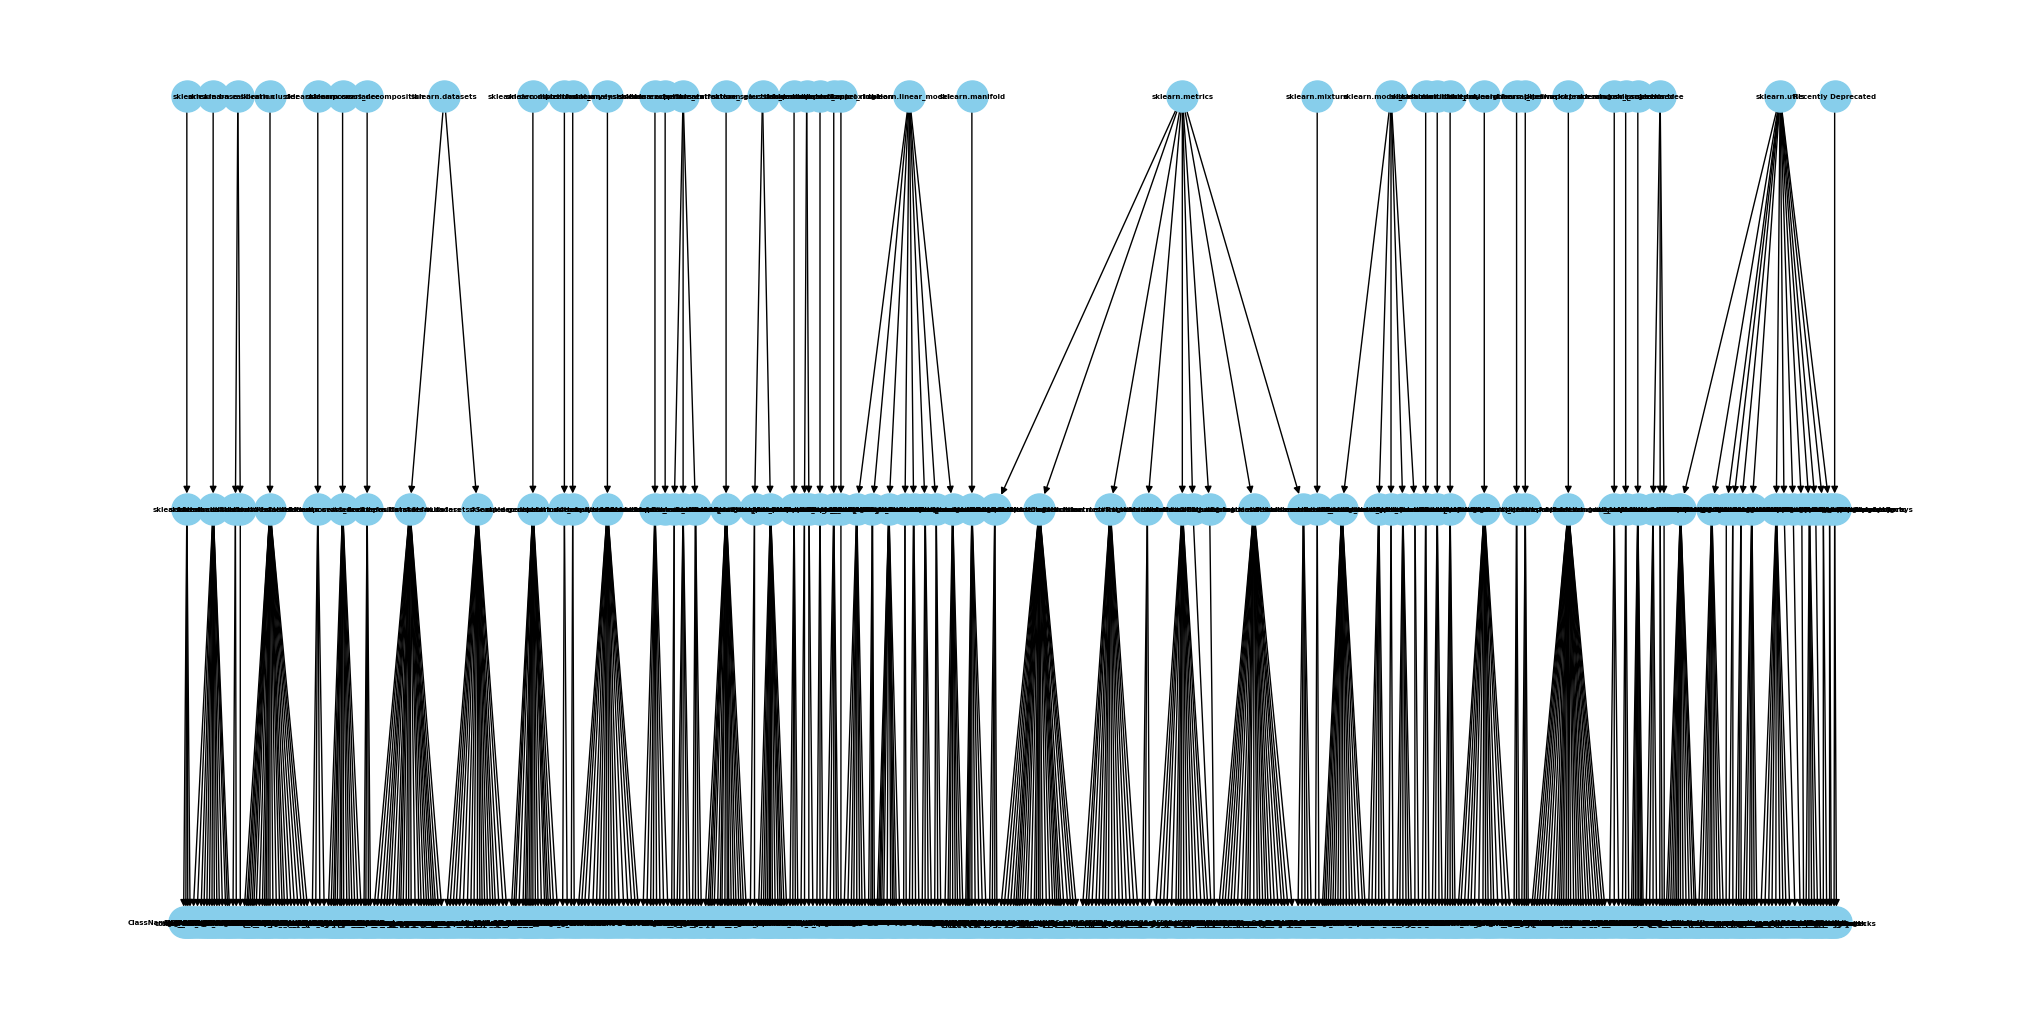

In [18]:
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
import networkx as nx

pos = graphviz_layout(sklearn_graph, prog="dot")
plt.figure(figsize=(20, 10))
nx.draw(sklearn_graph, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=5, font_weight="bold", arrows=True)
plt.show()

## SUMMARY BUILD

In [19]:
parent_dict = {node:[] for node,attr in sklearn_graph.nodes(data=True) if attr['type']=='parent_node'}

for node,attr in sklearn_graph.nodes(data=True):
    if attr['type'] == 'sub_level_node':
        parent_dict[attr['trail']].extend(attr['child_texts'])

In [20]:
parent_dict['sklearn']

['Context manager for global scikit-learn configuration. If True, validation for finiteness will be skipped,\nsaving time, but leading to potential crashes. If\nFalse, validation for finiteness will be performed,\navoiding error. If None, the existing value won’t change.\nThe default value is False. If set, scikit-learn will attempt to limit the size of temporary arrays\nto this number of MiB (per job when parallelised), often saving both\ncomputation time and memory on expensive operations that can be\nperformed in chunks. If None, the existing value won’t change.\nThe default value is 1024. If True, only the parameters that were set to non-default\nvalues will be printed when printing an estimator. For example,\nprint(SVC()) while True will only print ‘SVC()’, but would print\n‘SVC(C=1.0, cache_size=200, …)’ with all the non-changed parameters\nwhen False. If None, the existing value won’t change.\nThe default value is True. Changed in version 0.23: Default changed from False to True

In [105]:
import dspy
from dotenv import load_dotenv, find_dotenv
from tqdm import tqdm
import json
import os

load_dotenv(find_dotenv(),override=True)
class SummarizationGeneration(dspy.Signature):
    """You are given a list of descriptions of different functions separated by newline.
    Your task is to summarize all the text into coherent summary that covers all the functions descriptions.
    Make sure that no function description is left out of the final summary. Provide a detailed summary and cover all the function descriptions
    """

    function_descriptions = dspy.InputField(
        prefix="List of function descriptions: ",
        desc="list of function descriptions to be summarized",
    )
    summary = dspy.OutputField(
        prefix="Summary: ", desc="summary of all the function descriptions"
    )


summarization_llm = dspy.OpenAI(model="gpt-3.5-turbo-0125", max_tokens=4096,api_key=os.environ['OPENAI_API_KEY'])
dspy.settings.configure(lm=summarization_llm)


class SummarizationPipeline(dspy.Module):
    def __init__(self, parent_node, parent_text, MAX_WORDS: int = 500):
        self.parent_node = parent_node
        self.parent_text = [pt.replace("\n"," ") for pt in parent_text]
        self.summarization = dspy.Predict(SummarizationGeneration)
        self.MAX_WORDS = MAX_WORDS

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

    def split_description(self):
        split_s = []
        running_num_words = 0
        curr_func_string = ""
        for txt in self.parent_text:
            num_words = len(txt.split(" "))
            running_num_words += num_words
            if running_num_words > self.MAX_WORDS:
                running_num_words = num_words
                split_s.append(curr_func_string)
                curr_func_string = txt
            else:
                curr_func_string += txt + "\n"
        if split_s == []:
            split_s.append(curr_func_string)
        split_s = [s for s in split_s if s!=""]
        return split_s

    def forward(self):
        if len(self.parent_text) == 0:
            return ""
        split_s = self.split_description()
        summaries = ""
        pbar = tqdm(total=len(split_s), desc=f"For {self.parent_node}")
        for desc in split_s:
            summaries += self.summarization(function_descriptions=desc).summary + " "
            pbar.update(1)
        return summaries

In [106]:
with open(
        "parent_summary.json",
        "r",
        encoding="utf-8",
    ) as json_file:
    parent_summary_dict = json.load(json_file)

In [110]:
# for parent in parent_dict:
#     if parent_summary_dict[parent] == "":
#         print(f"Summarizing for {parent}")
#         summ_pipeline = SummarizationPipeline(parent, parent_dict[parent],MAX_WORDS=500)
#         summary = summ_pipeline()
#         parent_summary_dict[parent] = summary
#         # break

In [109]:
import json
json_object = json.dumps(parent_summary_dict, indent=4,ensure_ascii=True)
 
# Writing to sample.json
with open("parent_summary.json", "w") as outfile:
    outfile.write(json_object)

In [111]:
from agent.utils import get_parents_dict

parents_dict = get_parents_dict(sklearn_graph)